In [38]:
using ColoringNames
using Plots

In [7]:
cldata = load_munroe_data(dev_as_train=false, dev_as_test=true)

ColoringNames.ColorDatasets{MLLabelUtils.LabelEnc.NativeLabels{SubString{String},307},ColoringNames.ColorDataset{Array{Any,1},Array{Int64,2},Array{Float32,2}}}(MLLabelUtils.LabelEnc.NativeLabels{SubString{String},307}(SubString{String}["acid", "green", "adobe", "algae", "almost", "black", "amber", "amethyst", "apple", "apricot"  …  "vivid", "vomit", "warm", "watermelon", "weird", "wheat", "wine", "wintergreen", "wisteria", "yuck"], Dict("russet"=>251,"celery"=>84,"lipstick"=>196,"dull"=>137,"chocolate"=>91,"sepia"=>259,"fern"=>150,"sickly"=>263,"'s"=>248,"y"=>43…)), ColoringNames.ColorDataset{Array{Any,1},Array{Int64,2},Array{Float32,2}}(Any["acid green", "acid green", "acid green", "acid green", "acid green", "acid green", "acid green", "acid green", "acid green", "acid green"  …  "yuck", "yuck", "yuck", "yuck", "yuck", "yuck", "yuck", "yuck", "yuck", "yuck"], [1 1 … 307 307; 2 2 … 0 0; 0 0 … 0 0; 0 0 … 0 0], Float32[0.344113 0.855319 0.921569; 0.281905 0.744681 0.921569; … ; 0.376894

In [14]:
noml = TermToColorDistributionEmpirical(256)
train!(noml, cldata)

(Float32[0.0 0.00497512 … 0.0 0.0; 0.0 0.0199005 … 0.0 0.0; … ; 0.0 0.00497512 … 0.0 0.00564972; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.00673401 0.0 … 0.0 0.00847458; 0.010101 0.00497512 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.026936 0.00995025 … 0.0246914 0.0169492; 0.023569 0.00497512 … 0.0123457 0.00564972])

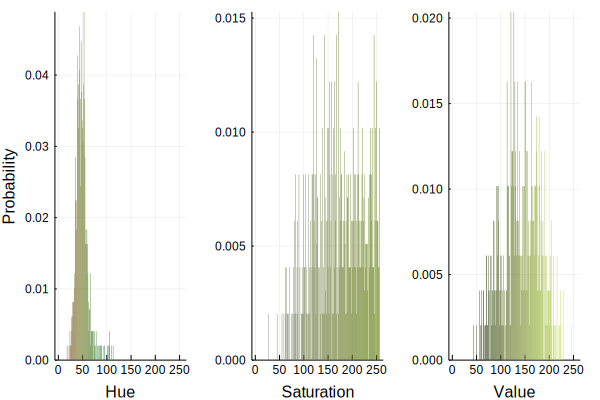

In [22]:
plot_hsv(query(noml,  "brownish green")...)

(h_max, s_max, v_max) = (0.09375, 1.0, 0.51953125)


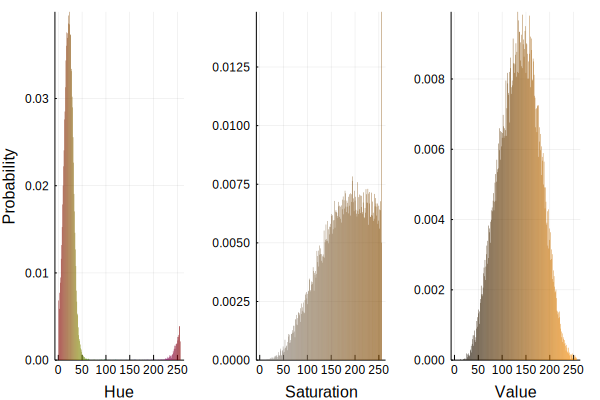

In [23]:
plot_hsv(query(noml,  "brown")...)

In [205]:
println(repr(round.(sat,3)))

Float32[0.855, 0.745, 0.921, 0.9, 0.992, 0.987, 0.466, 0.805, 0.95, 0.972, 0.956, 0.6, 0.422, 0.988, 0.844, 0.837, 0.877, 0.599, 0.986, 0.653, 0.892, 0.856, 0.853, 0.8, 0.712, 0.964, 0.493, 0.895, 0.807, 0.786, 0.855, 0.936, 0.96, 0.968, 0.794, 0.698, 0.884, 0.879, 0.755, 0.885, 0.898, 0.926, 0.694, 0.913, 0.559, 0.938, 0.974, 0.847, 0.92, 0.904, 0.807, 0.953, 0.612, 0.952, 0.954, 0.966, 0.976, 0.836, 0.743, 0.935, 0.884, 0.946, 0.948, 0.899, 0.82, 0.921, 0.877, 0.941, 0.953, 0.985, 0.87, 0.987, 0.589, 0.61, 0.741, 0.966, 0.948, 0.914, 0.68, 0.901, 0.725, 0.594, 0.903, 0.924, 0.955, 0.845, 0.962, 0.768, 0.779, 0.587, 0.937, 0.899, 0.914, 0.877, 0.897, 0.926, 1.0, 0.889, 0.866, 0.901, 0.988, 0.85, 0.805, 0.878, 0.912, 0.698, 0.958, 0.963, 0.967, 0.711, 0.958, 0.825, 0.93, 0.889, 0.99, 0.659, 0.727, 0.794, 0.957, 0.52, 0.956, 0.939, 0.716, 0.957, 0.77, 0.586, 0.982, 0.897, 0.922, 0.769, 0.935, 0.915, 0.868, 0.803, 0.816, 0.844, 0.902, 0.776, 0.967, 0.882, 0.943, 0.767, 0.768, 0.883, 0.96

In [204]:
?round

search: round rounding RoundUp RoundDown RoundToZero RoundingMode RoundNearest



```
round(z, RoundingModeReal, RoundingModeImaginary)
```

Returns the nearest integral value of the same type as the complex-valued `z` to `z`, breaking ties using the specified [`RoundingMode`](@ref)s. The first [`RoundingMode`](@ref) is used for rounding the real components while the second is used for rounding the imaginary components.

```
round([T,] x, [digits, [base]], [r::RoundingMode])
```

Rounds `x` to an integer value according to the provided [`RoundingMode`](@ref), returning a value of the same type as `x`. When not specifying a rounding mode the global mode will be used (see [`rounding`](@ref)), which by default is round to the nearest integer ([`RoundNearest`](@ref) mode), with ties (fractional values of 0.5) being rounded to the nearest even integer.

```jldoctest
julia> round(1.7)
2.0

julia> round(1.5)
2.0

julia> round(2.5)
2.0
```

The optional [`RoundingMode`](@ref) argument will change how the number gets rounded.

`round(T, x, [r::RoundingMode])` converts the result to type `T`, throwing an [`InexactError`](@ref) if the value is not representable.

`round(x, digits)` rounds to the specified number of digits after the decimal place (or before if negative). `round(x, digits, base)` rounds using a base other than 10.

```jldoctest
julia> round(pi, 2)
3.14

julia> round(pi, 3, 2)
3.125
```

!!! note
    Rounding to specified digits in bases other than 2 can be inexact when operating on binary floating point numbers. For example, the [`Float64`](@ref) value represented by `1.15` is actually *less* than 1.15, yet will be rounded to 1.2.

    ```jldoctest
    julia> x = 1.15
    1.15

    julia> @sprintf "%.20f" x
    "1.14999999999999991118"

    julia> x < 115//100
    true

    julia> round(x, 1)
    1.2
    ```


```
round(dt::TimeType, p::Period, [r::RoundingMode]) -> TimeType
```

Returns the `Date` or `DateTime` nearest to `dt` at resolution `p`. By default (`RoundNearestTiesUp`), ties (e.g., rounding 9:30 to the nearest hour) will be rounded up.

For convenience, `p` may be a type instead of a value: `round(dt, Dates.Hour)` is a shortcut for `round(dt, Dates.Hour(1))`.

```jldoctest
julia> round(Date(1985, 8, 16), Dates.Month)
1985-08-01

julia> round(DateTime(2013, 2, 13, 0, 31, 20), Dates.Minute(15))
2013-02-13T00:30:00

julia> round(DateTime(2016, 8, 6, 12, 0, 0), Dates.Day)
2016-08-07T00:00:00
```

Valid rounding modes for `round(::TimeType, ::Period, ::RoundingMode)` are `RoundNearestTiesUp` (default), `RoundDown` (`floor`), and `RoundUp` (`ceil`).


In [60]:
using KernelDensity


In [179]:
function do_not_smooth(data, npoints)
    midpoints = KernelDensity.kde_range((0,1), npoints)
    dist = KernelDensity.tabulate(data, midpoints)
    dist.density./=sum(dist.density)
    dist.density, dist.x
end

do_not_smooth (generic function with 1 method)

In [181]:
midpoints = KernelDensity.kde_range((0,1), 256)
dist = KernelDensity.tabulate(sat, midpoints)
dist.density./=sum(dist.density)
dist.density, dist.x

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0123484, 0.0501516, 0.0, 0.0, 0.0226525, 0.103335, 0.0615121, 0.0, 0.0], 0.0:0.00392156862745098:1.0)

In [177]:
function truncated_kde_smooth(data, npoints, kde_fun = kde_lscv)
    fake_boundry = (-0.5, 1.5)
    fake_npoints = 2npoints

    dist = kde_fun(data, npoints=fake_npoints, boundary=fake_boundry)
    density = dist.density
    density./=sum(density)
    inside = density[npoints÷2+1: end - npoints÷2]
    @assert length(inside)==npoints
    lower = @view density[1:npoints÷2]
    upper = @view density[end-npoints÷2+1:end]
    @assert length(lower)==npoints÷2
    @assert length(upper)==npoints÷2
    excess_mass = sum(lower) + sum(upper)
    @assert 0<=excess_mass<=0.5 
    inside./= 1-excess_mass
    @assert sum(inside)≈ 1
    inside, dist.x[npoints÷2+1: end - npoints÷2]
end

truncated_kde_smooth (generic function with 2 methods)

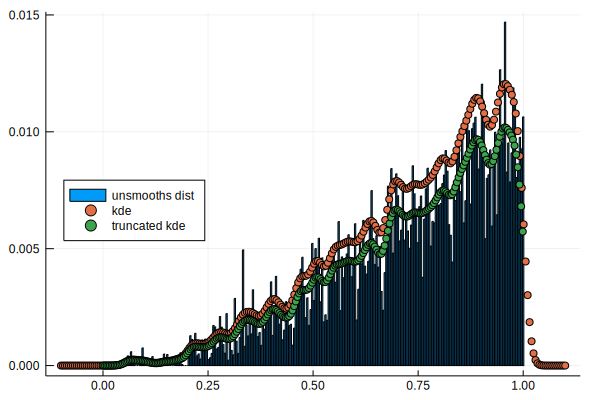

In [194]:
sat = cldata.train.colors[1:end÷900,2];
#histogram(sat, nbins=256; label="hist", norm=true, legend=:left)
ndist = do_not_smooth(sat, 256)
bar(ndist[2], ndist[1]; label="unsmooths dist", legend=:left)

dist = kde_lscv(sat, npoints=256, boundary=(-0.1,1.1))
scatter!(dist.x, dist.density./sum(dist.density) ; label="kde")
tdist = truncated_kde_smooth(sat, 256)
scatter!(tdist[2], tdist[1]; label="truncated kde")



In [136]:
function wraparound_kde_smooth(data, npoints)
    # Because of the periodic nature of FFT used to implement kde
    # It is actually wrap around by default
    # If you specify tight boundries
    boundry = (0, 1)
    dist = kde_lscv(data, npoints=npoints, boundary=boundry)
    dist.density./=sum(dist.density)
    
    dist.density, dist.x
end

wraparound_kde_smooth (generic function with 1 method)

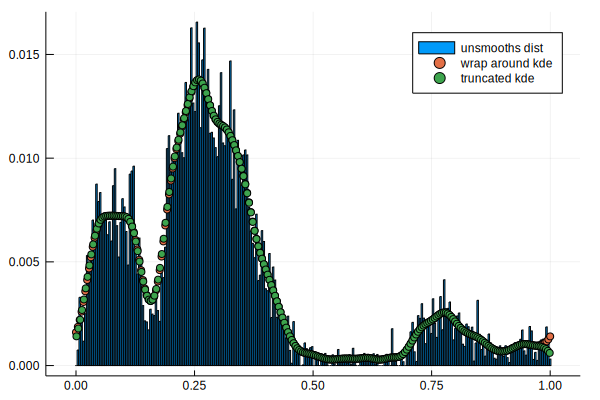

In [197]:
hue = cldata.train.colors[1:end÷900,1];
ndist = do_not_smooth(hue, 256)
bar(ndist[2], ndist[1]; label="unsmooths dist")
wdist = wraparound_kde_smooth(hue, 256)
scatter!(wdist[2], wdist[1]; label="wrap around kde")
tdist = truncated_kde_smooth(hue, 256)
scatter!(tdist[2], tdist[1]; label="truncated kde")


do_not_smooth (generic function with 1 method)

In [147]:
methods(KernelDensity.tabulate)

# 4 methods for generic function "tabulate":
tabulate(data::AbstractArray{T,1} where T<:Real, midpoints::Range) in KernelDensity at /home/wheel/oxinabox/.julia/v0.6/KernelDensity/src/univariate.jl:85
tabulate(data::AbstractArray{T,1} where T<:Real, midpoints::Range, weights::Union{AbstractArray{T,1} where T<:Real, KernelDensity.UniformWeights}) in KernelDensity at /home/wheel/oxinabox/.julia/v0.6/KernelDensity/src/univariate.jl:85
tabulate(data::Tuple{AbstractArray{T,1} where T<:Real,AbstractArray{T,1} where T<:Real}, midpoints::Tuple{Range,Range}) in KernelDensity at /home/wheel/oxinabox/.julia/v0.6/KernelDensity/src/bivariate.jl:30
tabulate(data::Tuple{AbstractArray{T,1} where T<:Real,AbstractArray{T,1} where T<:Real}, midpoints::Tuple{Range,Range}, weights::Union{AbstractArray{T,1} where T<:Real, KernelDensity.UniformWeights}) in KernelDensity at /home/wheel/oxinabox/.julia/v0.6/KernelDensity/src/bivariate.jl:30

In [170]:
?searchsortedfirst

search: searchsortedfirst searchsortedlast searchsorted



```
searchsortedfirst(a, x, [by=<transform>,] [lt=<comparison>,] [rev=false])
```

Returns the index of the first value in `a` greater than or equal to `x`, according to the specified order. Returns `length(a)+1` if `x` is greater than all values in `a`. `a` is assumed to be sorted.

# Examples

```jldoctest
julia> searchsortedfirst([1, 2, 4, 5, 14], 4)
3

julia> searchsortedfirst([1, 2, 4, 5, 14], 4, rev=true)
1

julia> searchsortedfirst([1, 2, 4, 5, 14], 15)
6
```
